## 1. Generalized linear model: Bioassay with Metropolis

### Bayesian Data Analysis, 3rd ed
####  Chapter 3, demo 6

Illustrate posterior inference for Bioassay data (BDA3 p. 74-).

### Module Setup

In [7]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import distributions

In [6]:

# Copyright (C) 1999 Simo Sarkka
# Copyright (C) 2003-2004,2013 Aki Vehtari
# Copyright (C) 2015 Tuomas Sivula

# This software is distributed under the GNU General Public Licence (version 3 
# or later); please refer to the file LICENSE.txt, included with the software, 
# for details.

from __future__ import division
import numpy as np

def psrf(X, return_extra=False):
    """Potential Scale Reduction Factor
    
    Potential Scale Reduction Factor (PSRF) for a collection of 
    MCMC-simulations. The idea of the PSRF is that if R is not close to 1 
    (below 1.1 for example) one may conclude that the tested samples were not 
    from the same distribution (chain might not have been converged yet).
    
    Original method:
       Brooks, S.P. and Gelman, A. (1998) General methods for monitoring 
       convergence of iterative simulations. Journal of Computational and 
       Graphical Statistics. 7, 434-455. 
    Current version:
       Split chains, return square-root definiton of R, and compute n_eff using 
       variogram estimate and Geyer's initial positive sequence as described in 
       Gelman et al (2013), Bayesian Data Analsyis, 3rd ed, sections 11.4-11.5.
    
    Parameters
    ----------
    X : array_like
        Input array of shape (M,N,D) consisting of M MCMC simulations of length 
        N, each with dimension D. Only one simulation can be provided as array 
        with shape (N,D). Preferably X should be C-contiguous with even number 
        of samples N.
    
    return_extra : bool, optional
        If True, some extra information is also returned, see section returns.
    
    Returns
    -------
    R : ndarray
        PSRF (R=sqrt(V/W)) in array of length D.
    
    neff : ndarray
        Estimated effective number of samples M*N/(1+2*sum(rhohat)).
    
    V : ndarray
        Estimated mixture-of-sequences variances.
    
    W : ndarray
        Estimated within sequence variances.
    
    B : ndarray
        Estimated between sequence variances.
    
    """
    
    # Handle input
    X = np.asarray(X)
    if X.ndim == 2:
        X = X[np.newaxis]
    # Split chains
    M = X.shape[0]*2
    N = X.shape[1]//2
    D = X.shape[2]
    if X.shape[1]%2 == 0:
        X = X.reshape((M,N,D))
    else:
        # Discard the middle samples (data copied)
        X_in = X
        X = np.empty((M,N,D), dtype=X_in.dtype)
        np.copyto(X[:X_in.shape[0]], X_in[:,:N])
        np.copyto(X[X_in.shape[0]:], X_in[:,-N:])
    
    if N <= 2:
        raise ValueError("Too few samples")
    
    # Means of the variances
    W = np.mean(np.var(X, axis=1, ddof=1), axis=0)
    # Variances of the means
    B = np.var(np.mean(X, axis=1), axis=0, ddof=1)
    
    # Calculate reduction factors
    Vh = W*(N-1)/N + B
    B *= N
    R = np.sqrt(Vh/W)
    
    if not return_extra:
        return R
    
    else:
        # Autocorrelation
        temp_1 = np.empty_like(X)
        rho = np.ones((N,D))
        for t in xrange(1,N):
            tempslice = temp_1[:,:-t]
            np.subtract(X[:,:-t], X[:,t:], out=tempslice)
            np.square(tempslice, out=tempslice)
            np.sum(tempslice, axis=(0,1), out=rho[t])
            rho[t] /= 2*M*(N-t)*Vh
        np.subtract(1, rho[1:], out=rho[1:])
        
        # Effective sample size
        mid = N//2
        cp = np.sum(np.reshape(rho[:2*mid], (mid,2,D)), axis=1)
        # The following could be Cythonised
        ci = np.argmax(cp<0, axis=0)
        no_init_pos = np.nonzero(np.all(cp>=0, axis=0))[0]
        if len(no_init_pos) > 0:
            print (
                "Initial positive could not be found for variable(s) {}, "
                "maxlag value used.".format(no_init_pos+1)
            )
            ci[no_init_pos] = mid
        cp *= np.arange(mid)[:,np.newaxis] < ci
        tau = -1 + 2*np.sum(cp, axis=0)
        neff = M*N/tau
        
        return R, neff, Vh, W, B, tau


### Data we are using here

In [3]:
| Dose, x_i  | Number of   | Number of    | 
| log(g/ml)  | animals,n_i |  deaths, y_i |
|:-----------|------------:|:------------:|
| -0.86      |     5       |     0        |
| -0.30      |     5       |     1        |
| -0.05      |     5       |     3        |
|  0.73      |     5       |     5        |

SyntaxError: invalid syntax (<ipython-input-3-b721147efe04>, line 1)

In [7]:
# Data from experiment
n=5
X=np.array([-0.86,-0.30,-0.05,0.73])
Y=np.array([0,1,3,5])

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$



In [8]:
def calc_posterior(a,b,x,y,n):
    '''
    unnormalized log posterior density for bioassay (assuming uniform prior)
    '''

    # these help using chain rule in derivation
    t = a + b*x
    et = np.exp(t)
    z = et/(1.+et)      
    #   print("t: {}\net: {}\n z: {}".format(t, et, z))
    # negative log posterior (error function to be minimized)
    lp = np.sum(y*np.log(z)+ (n-y)*np.log(1.-z))
    return(lp)

In [9]:
# check my posterior. I do a brute force just to make sure I do the right thing
X1 = np.linspace(-3,7,101)
X2 = np.linspace(-10, 30,100)
k=0;j=0
pp=np.zeros((101,100))
for x1 in X1:
    j=0
    for x2 in X2:
        pp[k,j]=calc_posterior(x1,x2, X, Y,n)
        j +=1
    k +=1
    
pp

array([[ -90.87880795,  -87.55476605,  -84.25232935, ...,  -25.19390609,
         -25.37457622,  -25.55526948],
       [ -90.77305181,  -87.43241521,  -84.11316577, ...,  -24.79991961,
         -24.98047051,  -25.1610469 ],
       [ -90.68374197,  -87.32654571,  -83.99045601, ...,  -24.4065572 ,
         -24.58697664,  -24.7674242 ],
       ..., 
       [-135.67403975, -132.54572843, -129.52465643, ...,  -13.32269935,
         -13.33286959,  -13.35031251],
       [-136.46838339, -133.37603216, -130.39174345, ...,  -13.48507282,
         -13.48867592,  -13.50012971],
       [-137.27476871, -134.21883034, -131.27124845, ...,  -13.65350117,
         -13.65003832,  -13.65503231]])

In [10]:
trace = np.empty((5+1, 2))
trace.shape
trace[0] = (2,2)
current_prob = np.exp(calc_posterior(*trace[0], X,Y,n))
current_prob


1.7328515586437636e-07

In [11]:
np.random.rand()

0.3699068781164355

In [12]:
rnorm = np.random.normal
runif = np.random.rand

# importlib.reload(calc_posterior)

def metropolis(n_iterations, initial_values, prop_var=1):
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_prob = calc_posterior(*trace[0],X,Y, n)
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000: print('Iteration', i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        for j in range(n_params):
            # This is the jumping distribution;
            # N ~ (current_params[j], prop_sd[j])
            # Usually its range is smaller than the posterior distribution
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
#             proposed_prob = calc_posterior(*p, X,Y, n)
            proposed_prob = calc_posterior(*p, X,Y, n)
            
            # Log-acceptance rate
            alpha = proposed_prob - current_prob
#             print("alpha: {}".format(alpha))
            
            # Sample a uniform random variate
            # In this case, u is different in every loop. However, it may be
            # constant over the entire loops.
            u = runif()
    
            # Test proposed value
            '''
            If α ≥ 1, then the candidate is more likely than xt; automatically 
            accept the candidate by setting xt+1 = x'. Otherwise, accept the 
            candidate with probability α; if the candidate is rejected, set 
            xt+1 = xt, instead.
            '''
            if (u) < np.exp(alpha):
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1

            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            p[j] = trace[i+1,j]
    return trace, accepted

## also define a better autocorr function 
def autocorr(x):
   result = np.correlate(x, x, mode='full')
   result = result/result[result.size/2]
   return result[result.size/2:]

In [13]:
n_iter = 50000
initial_values = [
    (3,20),
    (1,30),
    (-2,9),
    (5,1)
]
trace = []; acc = []

for i in initial_values:
    t, a = metropolis(n_iter, i)
    trace.append(t)
    acc.append(a)

Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000
Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000
Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000
Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000


For many models, convergence occurs quickly. It is not uncommon that convergence happens within a few hundred iterations (__burn-in__), after which all remaining samples of the chain may be used to calculate posterior quantities. For complex models, convergence requires a significantly longer __burn-in__ time. Frequently, lack of convergence will be caused by __poor mixing__. Mixing refers to the degree to which the __Markov chain explores the support of the posterior distribution__. Poor mixing may be due to inappropriate __proposals__ (too small step) or from attempting to estimate models with highly correlated variables.

In [14]:
burnin = 5000    # MY BURN IN 
trace_without_warm_up = [t[burnin:] for t in trace]

In [15]:
Rs = psrf(trace_without_warm_up)
print("Rhat for alpha:{:10.6f}\nRhat for beta: {:10.6f}".format(*Rs))

Rhat for alpha:  1.001431
Rhat for beta:   1.002747


In [16]:
alpha = np.concatenate(trace_without_warm_up)[burnin:,0];
beta = np.concatenate(trace_without_warm_up)[burnin:,1];

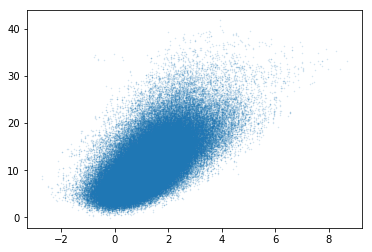

In [17]:
plt.scatter(alpha, beta, s=0.2, alpha=0.2)

The plot looks similar to the Figure 3.3b
![f3.3](images/bioassasy_example.png)

## 2. Bioassay with Stan

In [2]:
# Data and model
import pystan

bioassay_code = """
data {
    real x[4];
    int<lower=0> n[4];
    int<lower=0> y[4];
}
parameters {
    real theta1;
    real theta2;
} 
model {
    real alpha_betax[4];
    for (i in 1:4) {
        alpha_betax[i] = theta1 + theta2*x[i];
    }
    y ~ binomial_logit(n,alpha_betax);
}
"""


bioassay_dat = {'x': [-0.86, -0.30, -0.05, 0.73],
                'n': [5] * 4,
               'y': [0, 1, 3, 5]
               }

In [3]:
sm = pystan.StanModel(model_code=bioassay_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_506026ccf78622ea3d6b124faa308770 NOW.


In [4]:
fit = sm.sampling(data=bioassay_dat,iter=1000, chains=4, seed=194838); fit

Inference for Stan model: anon_model_506026ccf78622ea3d6b124faa308770.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1   1.37    0.04   1.08   -0.5   0.62   1.27   2.03    3.8    594   1.01
theta2  11.77    0.24   5.55   3.82   7.46  10.96   15.2   24.3    527   1.01
lp__    -6.97    0.05   1.11  -9.92  -7.41  -6.64  -6.21  -5.92    555    1.0

Samples were drawn using NUTS at Fri Oct 27 18:28:34 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [5]:
         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1   1.28    0.05   1.05  -0.57   0.55   1.18   1.92   3.52    480    1.0
theta2  11.38    0.24   5.66   3.44   7.17   10.3  14.61  24.86    536    1.0
lp__    -6.93    0.04   0.99  -9.51  -7.39  -6.61  -6.19  -5.92    662   1.01

SyntaxError: invalid syntax (<ipython-input-5-34d3d032626d>, line 1)

$\hat{R}$ for $\alpha$ and $\beta$ are both 1.0.

In [9]:
samples = fit.extract(permuted=True)

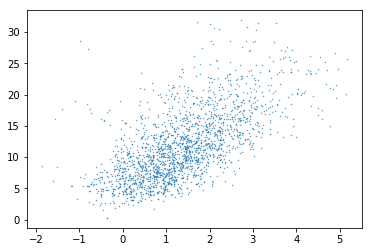

In [10]:
plt.scatter(samples['theta1'], samples['theta2'], s=0.2, alpha=0.8)

![bioassay_metropolis_posterior.png](images/bioassay_metropolis_posterior.png)

The plot looks similar to the Figure 3.3b
![f3.3](images/bioassasy_example.png)